In [2]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('using device:', device)

using device: cuda


In [3]:
from model import create_model

# n_classes = 251
n_classes = 513
model = create_model(n_classes, device)

In [4]:
CHECKPOINTS = [1, 10, 30, 50, 80, 100]
BATCH_SIZE = 256
SNRS = [-12, -6, -3, 0, 2, 6, 12]
N = len(SNRS)

In [ ]:
import numpy as np
import pandas as pd
from model import eval_acc, load_model_checkpoint, load_dataset

load_model_checkpoint('checkpoints/newnew/model-ckpt-e27.pt', model, device=device)

noise_conds = ['babble', 'music', 'outdoor']
d = {'SNR': [], 'noise_type': [], 'accuracy': []}
ckpt_path = 'checkpoints/newnew'
for noise in noise_conds:
    for snr in SNRS:
        acc = []
        for i in range(0, 40):
            X_test, y_test = load_dataset(f'model_train/test{snr}dB', f'inputs_{noise}_{i}.npy', f'targets_{noise}_{i}.npy')
            acc.append(eval_acc(model, X_test, y_test, device, bs=BATCH_SIZE))
        d['SNR'].append(snr)
        d['noise_type'].append(noise)
        d['accuracy'].append(np.mean(acc))
df = pd.DataFrame(d)

In [ ]:
import os
import pandas as pd
from model import eval_acc, load_model_checkpoint

epochs = 28

training_losses = np.load('train_losses_newnew.npy')
validation_losses = np.load('valid_losses_newnew.npy')

noise_conds = ['babble', 'music', 'outdoor']
d = {'epoch': [], 'train_loss': [], 'validation_loss': [], 'train_accuracy': [], 'validation_accuracy': []}
ckpt_path = 'checkpoints/newnew'
for e in range(epochs):
    f = f'model-ckpt-e{e}.pt'
    model_file = os.path.join(ckpt_path, f)
    ckpt = load_model_checkpoint(model_file, model, device=device)
    tr_acc = []
    for i in range(360):
        X_train, y_train = load_dataset('model_train', f'inputs_{i}.npy', f'targets_{i}.npy')
        tr_acc.append(eval_acc(model, X_train, y_train, device, bs=BATCH_SIZE))
    tr_acc = np.mean(tr_acc)
    valid_accs = {}
    for n in noise_conds:
        te_acc = []
        for i in range(360, 400):
            X_test, y_test = load_dataset('model_train', f'inputs_{n}_{i}.npy', f'targets_{n}_{i}.npy')
            te_acc.append(eval_acc(model, X_test, y_test, device, bs=BATCH_SIZE))
        valid_accs[n] = np.mean(te_acc)
    d['epoch'].append(e)
    EE = e * 361 + 360 # because accidentally appended to losses
    d['train_loss'].append(training_losses[EE])
    d['validation_loss'].append(validation_losses[EE])
    d['train_accuracy'].append(tr_acc)
    d['validation_accuracy'].append(valid_accs)
df = pd.DataFrame(d)

In [ ]:
df

In [ ]:
df.to_pickle('training_results.pkl')

In [9]:
from model import eval_acc, load_dataset, load_model_checkpoint

# accs = [0] * N

accs = {}

ckpt_path = 'checkpoints/newest/model-ckpt-eEPOCH.pt'

for epoch in CHECKPOINTS:
    ckpt = ckpt_path.replace('EPOCH', str(epoch))
    load_model_checkpoint(ckpt, model, device=None)
    model.eval()
    accs[str(epoch)] = [0] * N
    for i, snr in enumerate(SNRS):
        path = f'model_train/test{snr}dB'
        X_test, y_test = load_dataset(path)
        te_acc = eval_acc(model, X_test, y_test, device, bs=BATCH_SIZE)
        accs[str(epoch)][i] = te_acc

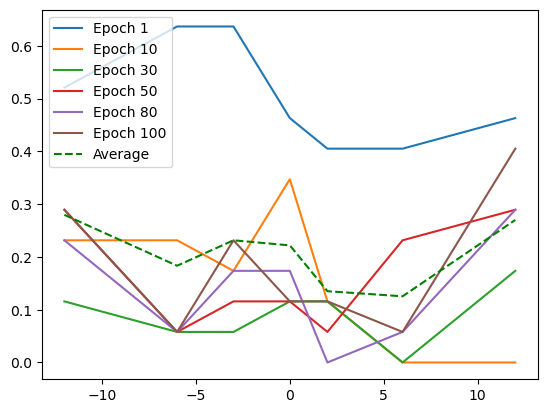

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

ax = plt.subplot()

for e in CHECKPOINTS:
    accs_arr = np.array(accs[str(e)]) * 100
    ax.plot(SNRS, accs_arr, label=f'Epoch {e}')

avgs = np.mean(list(accs.values()), axis=0) * 100
ax.plot(SNRS, avgs, 'g--', label='Average')

ax.legend()

In [21]:
from model import eval_acc, load_dataset, load_model_checkpoint

# accs = [0] * N

noise_accs = {}

NOISE_CONDS = ['babble', 'music', 'outdoor']

loaded_epoch = 100

ckpt_path = f'checkpoints/newest/model-ckpt-e{loaded_epoch}.pt'

load_model_checkpoint(ckpt_path, model, device=None)
model.eval()
for n in NOISE_CONDS:
    noise_accs[n] = [0] * N
    for i, snr in enumerate(SNRS):
        path = f'model_train/test{snr}dB'
        X_test, y_test = load_dataset(path, inputs_file=f'inputs_{n}.npy', targets_file=f'targets_{n}.npy')
        te_acc = eval_acc(model, X_test, y_test, device, bs=BATCH_SIZE)
        noise_accs[n][i] = te_acc

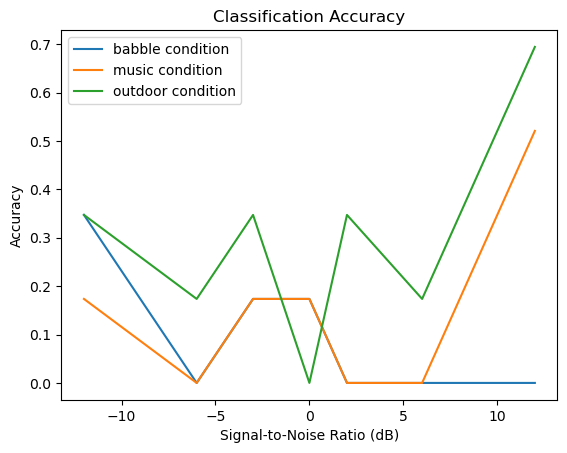

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
ax = plt.subplot()

for n in NOISE_CONDS:
    accs_arr = np.array(noise_accs[n]) * 100
    ax.plot(SNRS, accs_arr, label=f'{n} condition')
    ax.set_title('Classification Accuracy')
    ax.set_xlabel('Signal-to-Noise Ratio (dB)')
    ax.set_ylabel('Accuracy')

ax.legend()
plt.savefig(f'class_acc_e{loaded_epoch}.svg')
plt.show()